In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from IPython.display import display, HTML, clear_output

from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
TEXT_COLOR = 'white'
BG_COLOR = 'black'
plt.rcParams['axes.facecolor'] = BG_COLOR
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['text.color'] = TEXT_COLOR
plt.rcParams['axes.labelcolor'] = TEXT_COLOR
plt.rcParams['xtick.color'] = TEXT_COLOR
plt.rcParams['ytick.color'] = TEXT_COLOR

# TODO https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

In [3]:

# TODO :
# faire une base d'evaluation en plus de train et test
# implementer un systeme d'epoch complet avec tf.dataset
# ajouter les données non supervisées au discriminateur => extraction des feature des texte non labelisé à faire
# annulation de la loss du label parametrable (lors de l'utilisation des data non supervisé), faisable en ajoutant des boolean au discriminateur faisant office de mask
# Masking loss : https://stackoverflow.com/questions/64130293/custom-loss-function-in-keras-with-masking-array-as-input

#multi output loss https://datascience.stackexchange.com/questions/86700/custom-loss-function-with-multiple-outputs-in-tensorflow

# https://ledatascientist.com/analyse-de-sentiments-avec-camembert/
# https://ledatascientist.com/introduction-a-la-categorisation-de-textes/
# https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification
# https://lbourdois.github.io/blog/nlp/BERT/


# I. Preparation des données

## A. Features extraction

In [2]:
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig
# config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=False)
# camembert = TFCamembertModel.from_pretrained("camembert-base", config=config)
refaire_extraction = False
if(refaire_extraction):

	camembert = TFCamembertModel.from_pretrained("camembert-base")
	tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

	class CustomCamemBERT(tf.keras.Model):
		def __init__(self, camembert, tokenizer):
			super().__init__()
			self.tokenizer = tokenizer
			self.cam = camembert
			self.GAP = GlobalAveragePooling1D()
			# self.GAP = Flatten()

		def call(self, inputs):
			l = tf.reshape(tf.convert_to_tensor(()), (0, 768 * 1))
			for sentence in inputs:
				# print("\nSentence:", sentence)
				tokenized = tokenizer.tokenize(sentence)
				# print(tokenized)
				encoded = tokenizer.encode(tokenized)
				# print(encoded)
				# print(tokenizer.decode(encoded))
				encoded_sentence = tf.constant([encoded], dtype=tf.int32)
				# print("Sentence encoded:", encoded_sentence.numpy())
				x = self.cam(encoded_sentence).last_hidden_state
				# print(x.shape)
				x = x[:,0,:]
				#x = self.GAP(x)
				# x = tf.reduce_mean(x, axis=1)
				# print("x", x)
				l = tf.concat([l, x], 0)
			# print("l", l)
			return l

	# tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
	# encoded_sentence = tf.constant([tokenizer.encode(tokenizer.tokenize("J'aime le camembert !"))], dtype=tf.int32)
	# print(encoded_sentence)
	# camembert(encoded_sentence)

	NLP_model = CustomCamemBERT(camembert, tokenizer)
	NLP_model.trainable = False

	# display(model("J'aime le camembert !"))
	features = NLP_model(["J'adore le camembert", "J'aime le camembert", "J'aime pas le camembert", "Je déteste le camembert"])
	# features = NLP_model(["femme", "homme", "roi", "renne"])
	# features = features.numpy()
	# display(features)
	# features.shape
	# for i in range(len(features)):
	# 	display(np.sqrt(np.sum((features[1] - features[i]) ** 2)))

	np.sqrt(np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis = -1))
	# TODO : tester le distance de ces deux vecteurs avec 2 autre "je deteste le camenbert" et "j'adore le camenbert"

In [3]:
if(os.path.isfile('./featured.csv')):
	sup = np.genfromtxt('featured.csv', delimiter=',')
	print(np.unique(sup[:, :1], return_counts=True))
else:
	sup = pd.read_csv("./supervise.csv")[["text", "label_shufan"]]
	features = NLP_model(sup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = np.array([sup["label_shufan"]]).T
	sup = np.concatenate([labels, features], axis=1)
	np.savetxt('featured.csv', sup, delimiter=",")

	moresup = pd.read_csv("./newdata.csv")[["text", "Classification"]]
	mapping = {'observation':1, 'information':0, 'hors sujet':0, 'pub':0}
	moresup[["Classification"]] = moresup[["Classification"]].applymap(lambda s: mapping.get(s) if s in mapping else s)
	features = NLP_model(moresup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = moresup[["Classification"]].values
	moresup = np.concatenate([labels, features], axis=1)

	allsup = np.concatenate([sup, moresup])



(array([0., 1.]), array([566,  71], dtype=int64))


## B. Split train / test (cf schema)

In [4]:
_, c = np.unique(sup[:, 0], return_counts=True)
nb_observations = c[1]
sup_train = np.concatenate([sup[sup[:,0] == 1][:], sup[sup[:,0] == 0][0:nb_observations]])
sup_test_surplus = sup[sup[:,0] == 0][nb_observations:]
sup_train[:,0]

def odd_distribution(data):
	A, B = data[data[:, 0] == 1], data[data[:, 0] == 0]
	C = [None]*(len(A)+len(B))
	C[::2] = A
	C[1::2] = B
	return np.array(C)

sup_train = odd_distribution(sup_train)

sup_train[:,0]

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0.])

# II. Preparations des modèles

In [110]:
latent_dim = 100

def generate_noise(n_batch, latent_dim=100):
    return np.random.randn(latent_dim * n_batch).reshape((n_batch, latent_dim))

def generate_fake_samples(n_batch, labelN, generator):
	labels = np.repeat(labelN, n_batch)
	X_fake = generator.predict([generate_noise(n_batch, generator.inputs[0].shape[1]), labels])
	y_fake = [labels, np.repeat(0, n_batch)]
	return X_fake, y_fake

def select_real_samples(n_batch, labelN, dataset):
	dataset = dataset[dataset[:, 0] == labelN, :]
	ind = np.random.choice(len(dataset), size=n_batch, replace=False)
	labels = np.repeat(labelN, n_batch)
	X_real = np.array(dataset[ind, 1:].tolist())
	y_real =  [labels, np.repeat(1, n_batch)]
	return X_real, y_real

def train_d(discriminator, dataset, n_batch):
	# (n_batch, 768), ([label, validité])
	# X_real, y_real = select_real_samples(n_batch, 0, dataset=dataset)
	# d_real_0 = discriminator.train_on_batch(X_real, y_real)

	# X_real, y_real = select_real_samples(n_batch, 1, dataset=dataset)
	# d_real_1 = discriminator.train_on_batch(X_real, y_real)
	d_real = []
	d_fake0 = []
	d_fake1 = []

	for step, (x_batch_train, y_batch_train) in enumerate(dataset):
		# print(x_batch_train.shape, y_batch_train.shape)
		d_real.append(D.train_on_batch(x_batch_train, y_batch_train))
		# y_pred = D.predict(x_batch_train)[0] # 0 c'est la prediction du label
		
		X_fake, y_fake = generate_fake_samples(n_batch, 0, generator=G)
		d_fake0.append(discriminator.train_on_batch(X_fake, y_fake))

		X_fake, y_fake = generate_fake_samples(n_batch, 1, generator=G)
		d_fake1.append(discriminator.train_on_batch(X_fake, y_fake))

	# precision = tf.keras.metrics.Precision(thresholds=0.5, name="precision")
	# recall = tf.keras.metrics.Recall(thresholds=0.5, name="recall")
	# AUC = tf.keras.metrics.AUC(name="AUC")
	# metrics = [precision, recall, AUC]
	# les metrics peuvent êtres faites en dehors de la fonction pour ne les declarer que une fois

	# for metric in metrics:
	# 	metric.update_state(y_batch_train, y_pred)
	
	# res_metrics = [metric.result().numpy() for metric in metrics]

	# for metric in metrics:
	# 	metric.reset_states()

	# return (np.mean(d_real) + np.mean(d_fake)) * (1 / 2), *res_metrics
	# return (np.mean(d_real) + np.mean(d_fake)) * (1 / 2)

	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	d_real = np.mean(d_real, axis=0)
	d_fake0 = np.mean(d_fake0, axis=0)
	d_fake1 = np.mean(d_fake1, axis=0)
	losses = np.concatenate([[d_real], [d_fake0], [d_fake1]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses

def train_g(gan, n_batch, step):
	reality = np.repeat(0, n_batch)
	g_loss_1 = []
	g_loss_0 = []
	for s in range(step):
		labels = np.repeat(1, n_batch)
		noise = generate_noise(n_batch, latent_dim)
		g_loss_1.append(gan.train_on_batch([noise, labels], [labels, reality]))

		labels = np.repeat(0, n_batch)
		noise = generate_noise(n_batch, latent_dim)
		g_loss_0.append(gan.train_on_batch([noise, labels], [labels, reality]))
	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	g_loss_1 = np.mean(g_loss_1, axis=0) # possibilité d'avoir l'erreur par type de label pour voir si le G performe mieux sur un label plutôt qu'un autre, ici je moyenne le cas 1 et 0
	g_loss_0 = np.mean(g_loss_0, axis=0)
	losses = np.concatenate([[g_loss_1], [g_loss_0]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses

In [124]:
tf.config.run_functions_eagerly(False)
# tf.data.experimental.enable_debug_mode()

def accuracy(out: int = 0, flip: bool = False): 
	""" Genere les fonctions de metriques de precision pour les modèles GAN et D """
	def acc(y_true, y_pred): return tf.keras.metrics.binary_accuracy(y_true, flip - y_pred if flip else y_pred)
	return acc

"""
Cooeficient qui determine l'importance d'une prediction plutot qu'une autre (à traiter comme un meta-parametre)
K pondere l'erreur lié à la prediction de la realité de la donnée
1 - K pondere l'erreur lié à la prediction du label
"""
K = 0.5 # TODO tester ce meta praremetre lorrs des phases d'evaluation
# TODO optimisation if else en dehors de la fonction local
def reality_loss(flip: bool = False, k: float = K): 
	def f(y_true, y_pred):
		# print("reality_loss", '\n',tf.reshape(y_true, (-1,)),'\n', tf.reshape(y_pred, (-1,)))
		return (1 - k) * tf.keras.metrics.binary_crossentropy(y_true, flip - y_pred if flip else y_pred)
	return f

def label_loss(flip: bool = False, k: float = K): 
	def f(y_true, y_pred):
		# print("label_loss",'\n', tf.reshape(y_true, (-1,)),'\n', tf.reshape(y_pred, (-1,)))
		return k * tf.keras.metrics.binary_crossentropy(y_true, flip - y_pred if flip else y_pred)
	return f

def f1_score(precision, recall):
	return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
	
# @tf.function
# def discriminator_realityloss(y_true, y_pred):
# 	return reality_loss(y_true, y_pred)
# => reality_loss(flip = false)

def APS(y_true, y_pred):
	return average_precision_score(y_true, y_pred)

def top_bottom_std(d):
	data = np.array(d)
	data_means = np.mean(data, axis=0)
	data = np.where(data_means < data, np.ma.array(data, mask=data_means < data).mean(axis=0), data)
	std_bottom = np.std(data, axis=0)

	data = d
	data_means = np.mean(data, axis=0)
	data = np.where(data_means > data, np.ma.array(data, mask=data_means > data).mean(axis=0), data)
	std_top = np.std(data, axis=0)

	return data_means, std_bottom, std_top

In [125]:
def generator(latent_dim):
	noise = Input(shape=(latent_dim,), name="noise_input", dtype=tf.float32)
	label = Input(shape=(1,), name="label_input", dtype=tf.float32) 

	# label_embedding = Flatten()(Embedding(2, latent_dim, name="label_embeding")(label))
	a = Dense(32, activation="relu")(label)

	b = Dense(32, activation="relu")(noise)

	# x = Multiply(name="mult_label_noise")([noise, label_embedding])
	x = Concatenate(name="Combine_Inputs")([a, b])
	x = Dense(64, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(128, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	# out = Dense(768, kernel_initializer=tf.keras.initializers.RandomNormal(mean=np.mean(sup[:,1:]), stddev=np.std(sup[:,1:]), seed=None), name="Generated_Hidden_rep")(x) # initialisation pour un output "proche" des donné reel
	out = Dense(768, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), name="Generated_Hidden_rep")(x)
	return Model([noise, label], out, name="Generator")

def discriminator():
	hidden_rep = Input(shape=(768,), dtype=tf.float32, name="Hidden_rep_Input")
	x = Dense(512, activation="relu")(hidden_rep)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(256, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	
	Rout = Dense(1, activation="sigmoid", name="Reality")(x)    
	Lout = Dense(1, activation="sigmoid", name="Label")(x)    

	return Model(hidden_rep, [Lout, Rout], name="Discriminator"), Model(hidden_rep, Rout, name="Discriminator"), Model(hidden_rep, Lout, name="Discriminator") # https://stackoverflow.com/questions/48335212/how-to-prevent-backpropagation-after-compiling-a-keras-model


In [126]:
def creation_models(competition=True, lrs=(0.0005, 0.0005), latent_dim=100):
	dlr, glr = lrs
	D, D_R_only, D_L_only = discriminator()
	D.compile(loss={"Label":label_loss(flip = False), "Reality":reality_loss(flip = False)}, optimizer=tf.keras.optimizers.Adam(learning_rate=dlr)) # metrics={"Label":accuracy(flip=False), "Reality":accuracy(flip=False)},
	D_R_only.compile(loss=reality_loss(flip = False), optimizer=tf.keras.optimizers.Adam(learning_rate=dlr))
	D_L_only.compile(loss=label_loss(flip = False), optimizer=tf.keras.optimizers.Adam(learning_rate=dlr))
	D.trainable = False

	G = generator(latent_dim)
	G.compile()

	noise = Input(shape=(latent_dim,), name="GAN_input_noise")
	label = Input(shape=(1,), name="GAN_input_label")
	hidden_rep = G([noise, label])
	validity = D(hidden_rep)
	out0 = Lambda(lambda x: x, name="Label")(validity[0]) # juste pour le renomage des layers (sinon nom par defaut {Discriminator, Discriminator_1} bug tf ?)
	out1 = Lambda(lambda x: x, name="Reality")(validity[1])

	GAN = Model(inputs=[noise, label], outputs=[out0, out1], name="GAN")

	# cooperatif ou competition : 
	GAN.compile( loss = {"Label": label_loss(flip = competition), "Reality": reality_loss(flip = True)}, optimizer = tf.keras.optimizers.Adam(learning_rate=glr))
	# metrics = {"Label": accuracy(flip = competition), "Reality": accuracy(flip = True)},

	extractor = tf.keras.Model(inputs=D.inputs, outputs=D.layers[-3].output)
	extractor.trainable = False
	predictor = tf.keras.Model(inputs=extractor.output, outputs=D.output)
	predictor.trainable = False
	
	return (D, D_R_only, D_L_only, (extractor, predictor)), G, GAN

(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=True)

In [127]:
# tf.keras.utils.plot_model(GAN, "test.png", show_shapes=True, expand_nested=True)
D.summary(), GAN.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Hidden_rep_Input (InputLayer)  [(None, 768)]        0           []                               
                                                                                                  
 dense_313 (Dense)              (None, 512)          393728      ['Hidden_rep_Input[0][0]']       
                                                                                                  
 dropout_51 (Dropout)           (None, 512)          0           ['dense_313[0][0]']              
                                                                                                  
 batch_normalization_85 (BatchN  (None, 512)         2048        ['dropout_51[0][0]']             
 ormalization)                                                                        

(None, None)

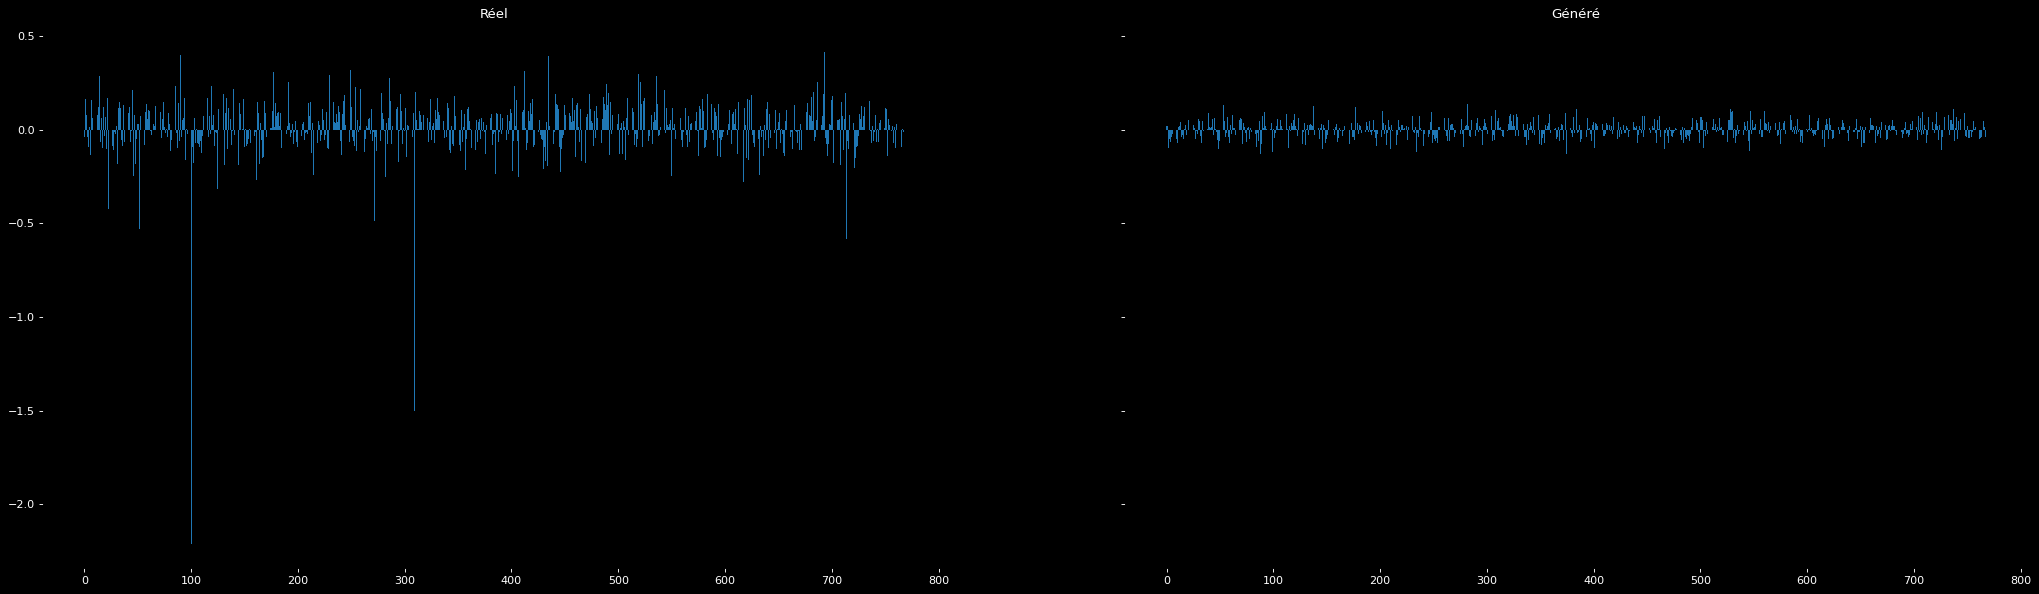

In [117]:
l = np.repeat(1, 1)
n = generate_noise(1, latent_dim)
pred_avant = G.predict([n, l])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16*2, 9), dpi=80)
axs[0].bar(range(768), sup[24,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré')
plt.show()

In [14]:
# l = np.tile([0, 1], int(244 / 2)).reshape((-1, 1))
# n = generate_noise(244, latent_dim)
# f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
# r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
# r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
# # add reality
# freality = np.repeat(0, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
# train_reality = np.repeat(1, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
# test_reality = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# # add label
# flabel = l.reshape((f2d.shape[0], f2d.shape[1], 1))
# train_label = sup_train[:,0].reshape((1, sup_train.shape[0], 1))
# test_label = sup_test[:,0].reshape((1, sup_test.shape[0], 1))
# # add predicction [plabel, preality]
# f2d_pred = predictor.predict(f2d[0])
# train_pred = predictor.predict(r2d_train[0])
# test_pred = predictor.predict(r2d_test[0])
# # alpha
# fa = np.repeat(1, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
# train_a = np.repeat(0.25, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
# test_a = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# #concatenation
# fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
# reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
# reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)

# data = np.concatenate([fakes, reels_train, reels_test], axis=1)
# data[0,0].tolist()
# # 0 = x
# # 1 = y
# # 2 = true_label
# # 3 = true_reality
# # 4 = pred_label
# # 5 = pred_reality
# # 6 = alpha
# plt.figure(figsize=(16, 9), dpi=80)
# MapColor = np.array(['r', 'g'])
# MapEdgecolor = np.array(['r', 'g'])
# MapMarkers = np.array(['o', 's'])
# s = 75
# es = 125 / s
# for _, m in enumerate(np.unique(data[0,:,2])):
# 	d = data[:,data[0,:,2] == m]
# 	plt.scatter(d[0,:,0], d[0,:,1], color=MapColor[d[0,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[0,:,5]).astype(int)], alpha=d[0,:,6], marker=MapMarkers[int(m)], s=s + s * d[0,:,4], linewidths=es)
# # couleur centrale = realité de la donnée (vert = reel, rouge = genere)
# # couleur de la bordure = prediction de la réalité de la donnée (vert = reel, rouge = genere)
# # carré = observation
# # rond = pas une observation

# III. Entraînement Semi-Supervisé

In [129]:
loss = tf.keras.metrics.BinaryCrossentropy(name="loss")
precision = tf.keras.metrics.Precision(thresholds=0.5, name="precision")
recall = tf.keras.metrics.Recall(thresholds=0.5, name="recall")
AUC = tf.keras.metrics.AUC(name="AUC")
metrics = [loss, precision, recall, AUC]
train_APS, test_APS = None, None

# x_train, y_train = sup_train[:, 1:], sup_train[:, 0]
# x_test, y_test = sup_test[:, 1:], sup_test[:, 0]

thresholds = 0.5



tf.config.run_functions_eagerly(False)
# tf.data.experimental.disabled_debug_mode()
training_ss_hist = []
n_Fold = 4
n_batch = 16
D_lr, G_lr = (0.0005, 0.0005)
competition = False
epochs = 20
k_fold = StratifiedKFold(n_splits=n_Fold)
X, y = sup_train[:, 1:], sup_train[:, :1]
for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
	# print('\nTrain: %s | test: %s' % (train_index.shape, test_index.shape))

	(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold

	
	test = np.concatenate([y[test_index], X[test_index]], axis=1)
	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus de non observations

	x_test, y_test = test[:, 1:], test[:, :1]
	x_train, y_train = X[train_index], y[train_index]
	
	# print(np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True))
	# print(y_train.reshape(-1,))

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(n_batch)
	train_dataset = train_dataset.batch(n_batch)

	
	register_every = 1
	pdhist = pd.DataFrame(columns=["D_loss","D_label_loss", "D_reality_loss", "G_loss", "G_label_loss", "G_reality_loss",  "loss", "Precision", "Recall", "AUC", "APS", "val_loss", "val_Precision", "val_Recall", "val_AUC", "val_APS"])
	hist = []
	for e in range(epochs):
		d_loss = train_d(D, train_dataset, n_batch)
		g_loss = train_g(GAN, n_batch, step=len(train_dataset))
		if(e % register_every == 0):
			y_pred_score = D.predict(x_train)[0].reshape(-1, )
			# y_pred = np.where(y_pred_score > thresholds, 1, 0)
			[metric.update_state(y_train, y_pred_score) for metric in metrics] # update
			train_metrics = [metric.result().numpy() for metric in metrics] # result
			[metric.reset_states() for metric in metrics] # reset
			train_APS = APS(y_train, y_pred_score)

			y_pred_score = D.predict(x_test)[0].reshape(-1, )
			# y_pred = np.where(y_pred_score > thresholds, 1, 0)
			[metric.update_state(y_test, y_pred_score) for metric in metrics] # update
			test_metrics = [metric.result().numpy() for metric in metrics] # result
			[metric.reset_states() for metric in metrics] # reset
			test_APS = APS(y_test, y_pred_score)
				
			# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
			# print(f"""
			# Precision: 	{precision}
			# Recall: 	{recall}
			# f1_score: 	{f1}
			# AUC: 		{AUC}
			# Matrice de confusion:\n{confusion_matrix}
			# """)

			"""
			f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
			r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
			r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
			# add predicction [plabel, preality]
			f2d_pred = predictor.predict(f2d[0])
			train_pred = predictor.predict(r2d_train[0])
			test_pred = predictor.predict(r2d_test[0])		
			#concatenation
			fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
			reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
			reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)		
			newdata = np.concatenate([fakes, reels_train, reels_test], axis=1)
			data = np.concatenate([data, newdata], axis=0)
			"""

			# hist.append([d_loss, g_loss, precision, recall, f1, AUC, train_precision, train_recall, train_f1, train_AUC])
			hist.append([*d_loss, *g_loss, *train_metrics, train_APS, *test_metrics, test_APS])
			pdhist = pdhist.append(pd.DataFrame([hist[-1]], columns=list(pdhist)), ignore_index=True)
			clear_output(wait=True)
			display(f"fold: {step}")
			display(pdhist.tail(10).round(2))
	# print(pdhist.to_dict('list'))
	training_ss_hist.append(pdhist.to_dict('list'))

# os.system("ffmpeg -r 1 -i ./training/e%01d.png -vcodec mpeg4 -y movie.mp4")
h = np.array(hist)


'fold: 1'

,D_loss,D_label_loss,D_reality_loss,G_loss,G_label_loss,G_reality_loss,loss,Precision,Recall,AUC,APS,val_loss,val_Precision,val_Recall,val_AUC,val_APS
0,0.89,0.44,0.45,0.68,0.35,0.34,0.67,0.62,1.00,0.82,0.77,0.71,0.05,0.94,0.76,0.16
1,0.76,0.40,0.36,0.66,0.35,0.31,0.65,0.81,0.87,0.91,0.87,0.66,0.09,0.72,0.81,0.23
2,0.68,0.36,0.32,0.64,0.36,0.28,0.64,0.91,0.74,0.93,0.90,0.62,0.18,0.72,0.84,0.26
3,0.64,0.35,0.29,0.60,0.36,0.24,0.62,1.00,0.28,0.95,0.94,0.52,0.27,0.17,0.85,0.28


20 (20,)


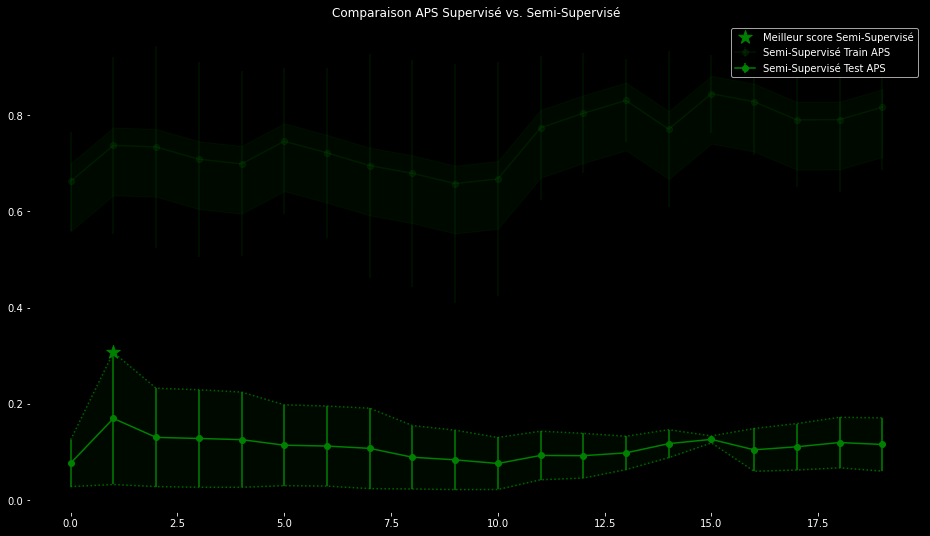

In [119]:
h_ss_train_APS = np.array([hs['APS'] for hs in training_ss_hist])
h_ss_test_APS = np.array([hs['val_APS'] for hs in training_ss_hist])

nb_epochs = np.array(h_ss_test_APS).shape[1]
print(nb_epochs, np.mean(h_ss_train_APS, axis=0).shape)
plt.figure(figsize=(16, 9))
alpha = 0.15
fmt = "-o"
plt.errorbar(range(nb_epochs), np.mean(h_ss_train_APS, axis=0), c="green", yerr=np.std(h_ss_train_APS, axis=0),label="Semi-Supervisé Train APS", alpha=alpha, fmt=fmt)
plt.errorbar(range(nb_epochs), np.mean(h_ss_test_APS, axis=0), c="green", yerr=np.std(h_ss_test_APS, axis=0),label="Semi-Supervisé Test APS", fmt=fmt)

train_mean = np.mean(h_ss_train_APS, axis=0)
train_std_top, train_std_bottom = np.std(h_ss_train_APS[h_ss_train_APS > train_mean], axis=0), np.std(h_ss_train_APS[h_ss_train_APS < train_mean], axis=0)
test_mean, test_std = np.mean(h_ss_test_APS, axis=0), np.std(h_ss_test_APS, axis=0)
plt.fill_between(range(nb_epochs), train_mean + train_std_top, train_mean - train_std_bottom, color="green", alpha=alpha/2)
plt.fill_between(range(nb_epochs), test_mean-test_std, test_mean+test_std, color="green", alpha=alpha/2)
# plt.plot(np.array(h_ss_test_APS).T, color="green", ls=":", alpha=alpha) # Tout
plt.plot(np.max(h_ss_test_APS, axis=0), color="green", ls=":", alpha=0.75) # min
plt.plot(np.min(h_ss_test_APS, axis=0), color="green", ls=":", alpha=0.75) # max

max_ss, e_ss = np.max(np.max(h_ss_test_APS, axis=0)), np.argmax(np.max(h_ss_test_APS, axis=0))
plt.scatter(e_ss, max_ss, label="Meilleur score Semi-Supervisé", marker='*', c='green', s=200)
plt.title("Comparaison APS Supervisé vs. Semi-Supervisé")
plt.legend()
# plt.ylim([0.85, 0.94])
plt.show()


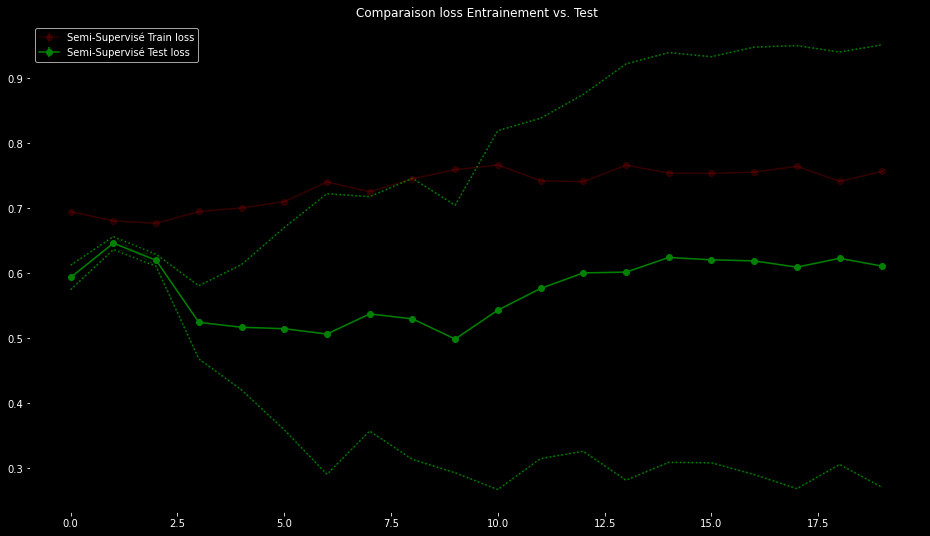

In [120]:
train_color, test_color = "red", "green"
metric = 'loss'

h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

plt.figure(figsize=(16, 9))
fmt = "-o"

plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=train_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train "+metric, alpha=alpha, fmt=fmt)
plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=test_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test "+metric, fmt=fmt)

plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=train_color, alpha=alpha/2)
plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=test_color, alpha=alpha)

plt.plot(np.array(h_ss_test).T, color=test_color, ls="--", alpha=0.25)
plt.plot(np.max(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)
plt.plot(np.min(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)

plt.title("Comparaison " + metric + " Entrainement vs. Test")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

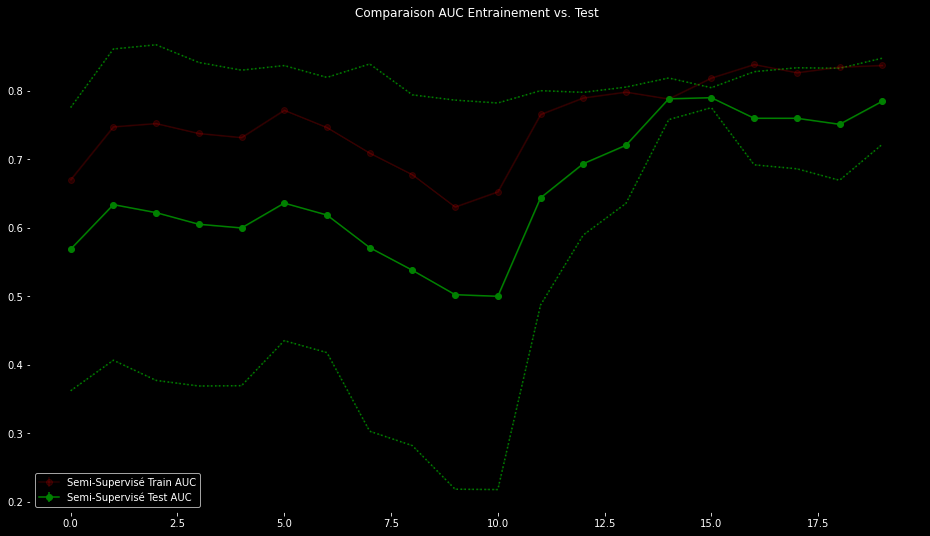

In [121]:
train_color, test_color = "red", "green"
metric = 'AUC'

h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

plt.figure(figsize=(16, 9))
fmt = "-o"

plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=train_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train "+metric, alpha=alpha, fmt=fmt)
plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=test_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test "+metric, fmt=fmt)

plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=train_color, alpha=alpha/2)
plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=test_color, alpha=alpha)

plt.plot(np.array(h_ss_test).T, color=test_color, ls="--", alpha=0.25)
plt.plot(np.max(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)
plt.plot(np.min(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)

plt.title("Comparaison " + metric + " Entrainement vs. Test")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

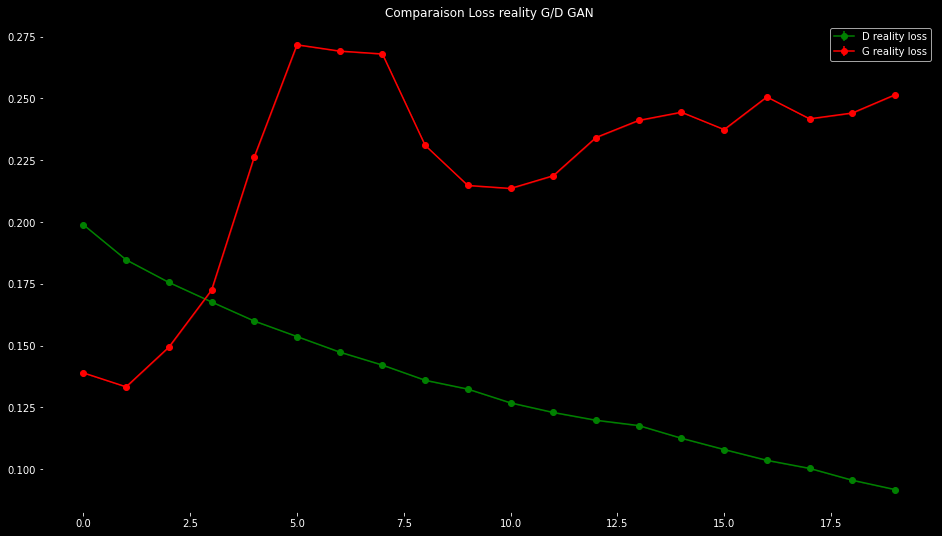

In [122]:
G_color, D_color = "red", "green"

G_loss = np.array([hs["G_reality_loss"] for hs in training_ss_hist])
D_loss = np.array([hs["D_reality_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D reality loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="G reality loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss reality G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

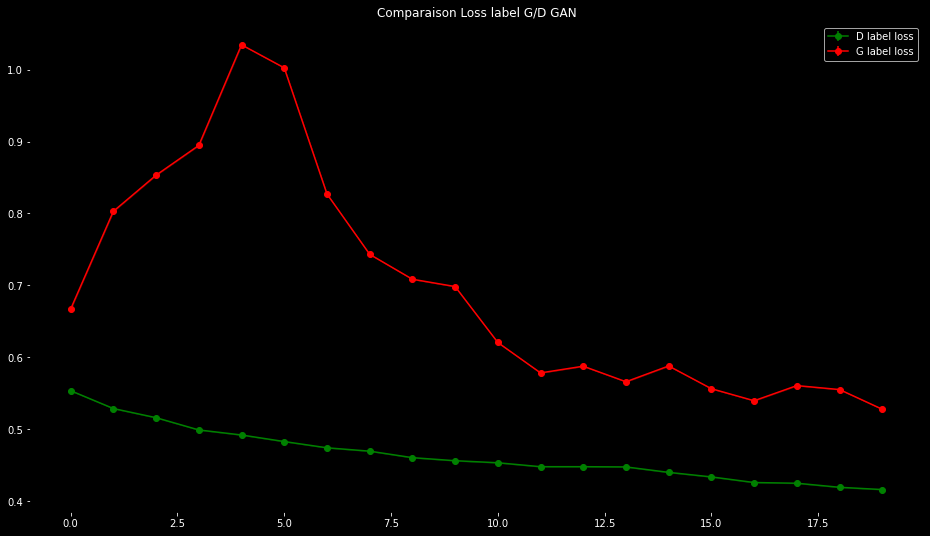

In [123]:
G_color, D_color = "red", "green"

G_loss = np.array([hs["G_label_loss"] for hs in training_ss_hist])
D_loss = np.array([hs["D_label_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D label loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="G label loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss label G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

In [15]:
# h = np.array(hist)

# def plot_metrics(metrics, data=pdhist, labels=None):
# 	labels = metrics if labels is None else labels
# 	fig, ax = plt.subplots(figsize=(16, 9))
# 	for m, l in zip(metrics, labels):
# 		ax.plot(data[m], label=l)
# 	ax.legend()
# 	return fig, ax


# fig, ax = plot_metrics(["loss", "val_loss"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["AUC", "val_AUC"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["APS", "val_APS"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["D_loss", "G_loss"], data=pdhist)
# fig.show()


# alpha = 0.25
# plt.figure(figsize=(16, 9))
# plt.plot(pdhist[["Precision"]], label="Test Precision")
# plt.plot(pdhist[["Recall"]], label="Test Recall")
# Testf1_v = [f1_score(p, r) for p, r in zip(pdhist[["Precision"]].values, pdhist[["Recall"]].values)]
# plt.plot(Testf1_v, label="Test F1")

# plt.plot(pdhist[["val_Precision"]], label="Test Precision")
# plt.plot(pdhist[["val_Recall"]], label="Test Recall")
# Testf1_v = [f1_score(p, r) for p, r in zip(pdhist[["val_Precision"]].values, pdhist[["val_Recall"]].values)]
# plt.plot(Testf1_v, label="Test F1")
# plt.legend()
# plt.show()

In [16]:
# thresholds = 0.5 # limite pour l'arrondissement

# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_score = D.predict(sup_test[:,1:])[0].reshape(-1, )
# y_pred = np.where(y_pred_score > thresholds, 1, 0)

# print(np.unique(y_true, return_counts=True))
# print(np.unique(y_pred, return_counts=True))
# """
# Matrice de confusion  | Pred 0 | Pred 1 | Total
# 			Réalité 0 |   VN   |   FP   | de non observation dans la base
# 			Réalité 1 |   FN   |   VP   | d'observation dans la base
# """
# # https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# # Precision
# # = VP / (VP + FP)
# # = VP / P
# # = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# # 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# # Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# # f1 = moyenne harmonique de Precision et Recall

# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Precision: 	{precision}
# Recall: 	{recall}
# f1_score: 	{f1}
# AUC: 		{AUC}
# Matrice de confusion:\n{confusion_matrix}
# """)

# # le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# # si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# # Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# # exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# # on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# # L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)

In [17]:
# from sklearn.metrics import roc_curve, roc_auc_score

# fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
# plt.figure(figsize=(9, 9))
# plt.plot(fpr, tpr)
# plt.plot([0, 1], ls="--", label="")
# plt.title('ROC curve')
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.xlim(0,)
# plt.ylim(0,)
# plt.show()

In [18]:
# # https://youtu.be/iCZJfO-7C5Q?t=656
# plt.figure(constrained_layout=True, figsize=(16, 9))
# x = (tpr + fpr) / 2 ** (0.5)
# y = (tpr - fpr) / 2 ** (0.5)
# plt.plot(x, y)
# plt.plot([0, max(x)], [0, 0], ls="--", label="random prediction")
# plt.title('ROC curve rotation à Pi/4')
# plt.xlabel('(TPR + FPR) / sqrt(2)')
# plt.ylabel('(TPR - FPR) / sqrt(2)')
# best_t = t[np.argmax(y)]
# # print(max(y), np.argmax(y), t, best_t)
# plt.scatter(x[np.argmax(y)], np.max(y), label=best_t, marker='*', c='red', s=200)
# plt.legend()
# plt.show()
# fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
# t[np.argmax(tpr - fpr)], best_t

In [19]:
# thresholds = 0.5
# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_scrore = D.predict(sup_test[:,1:])[0].reshape(-1, )
# y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Threshold {thresholds}
# {np.unique(y_true, return_counts=True)}
# {np.unique(y_pred, return_counts=True)}
# Precision: 	{precision*100:.2f}%
# Recall: 	{recall*100:.2f}%
# f1_score: 	{f1*100:.2f}%
# AUC: 		{AUC*100:.2f}%
# Matrice de confusion:\n{confusion_matrix}
# """)

# lp, lr, lf = precision, recall, f1

# thresholds = best_t
# y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Threshold {thresholds}
# {np.unique(y_true, return_counts=True)}
# {np.unique(y_pred, return_counts=True)}
# Precision: 	{precision*100:.2f}% ({(precision - lp)*100:+.2f}%)
# Recall: 	{recall*100:.2f}% ({(recall - lr)*100:+.2f}%)
# f1_score: 	{f1*100:.2f}% ({(f1 - lf)*100:+.2f}%)
# AUC: 		{AUC*100:.2f}%
# Matrice de confusion:\n{confusion_matrix}
# """)

# Visualisation de l'espace de decision pendant l'entraînement semi-supervisé

In [20]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	# ax1.set_xlim([-1., 1.])
# 	# ax1.set_ylim([-1., 1.])
# 	for _, m in enumerate(np.unique(data[i,:,2])):
# 		d = data[:,data[i,:,2] == m]
# 		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,5]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,4], linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# out

In [21]:
# with open('result_stable.html', 'w') as f:
# 	print("save...")
# 	f.write(out.data)

In [22]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	ax1.set_xlim([-1.1, 1.1])
# 	ax1.set_ylim([-1.1, 1.1])
# 	for _, m in enumerate(np.unique(data[i,:,3])):
# 		d = data[:,data[i,:,2] == m]
# 		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,5], linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# # with open('result2.html', 'w') as f:
# # 	print("save...")
# # 	f.write(out.data)

# out

In [23]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128

# # 0 = x
# # 1 = y
# # 2 = true_label
# # 3 = true_reality
# # 4 = pred_label
# # 5 = pred_reality
# # 6 = alpha

# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	# ax1.set_xlim([-1.1, 1.1])
# 	# ax1.set_ylim([-1.1, 1.1])
# 	d = data[:,data[i,:,3] == 1]
# 	ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6],s=s, linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# out

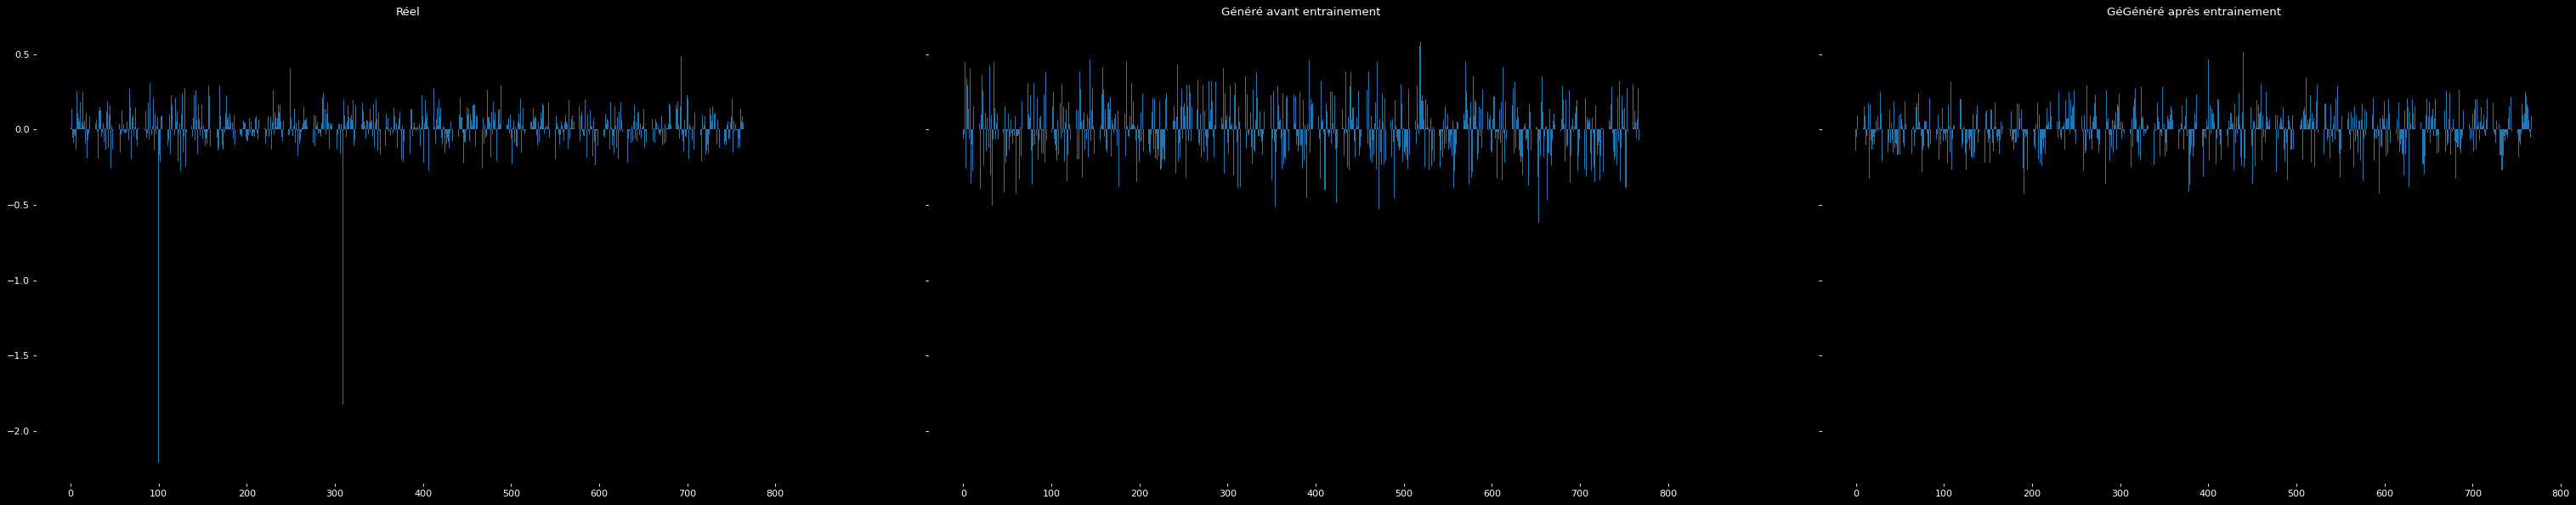

In [23]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16*3, 9), dpi=80)
pred_apres = G.predict([n, l])
axs[0].bar(range(768), sup[20,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré avant entrainement')
axs[2].bar(range(768), pred_apres[0])
axs[2].set(title='GéGénéré après entrainement')
plt.show()

In [25]:
# l = np.repeat(1, 100).reshape((-1, 1))
# n = generate_noise(100, latent_dim)
# w = 16 * 2
# h = 9
# dpi = 100
# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# pred_apres = G.predict([n, l])

# axs[0].bar(range(768), np.mean(sup[:,1:], axis=0))
# axs[0].set(title='Moyenne par composants des vecteurs réels')
# axs[1].bar(range(768), np.mean(pred_apres, axis=0))
# axs[1].set(title='Moyenne par composants des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.std(sup[:,1:], axis=0))
# axs[0].set(title='Ecart type des vecteurs réels')
# axs[1].bar(range(768), np.std(pred_apres, axis=0))
# axs[1].set(title='Ecart type des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.max(sup[:,1:], axis=0))
# axs[0].set(title='Max des composants des vecteurs réels')
# axs[1].bar(range(768), np.max(pred_apres, axis=0))
# axs[1].set(title='Max des composants des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.min(sup[:,1:], axis=0))
# axs[0].set(title='Min descomposants des vecteur réels')
# axs[1].bar(range(768), np.min(pred_apres, axis=0))
# axs[1].set(title='Min descomposants des vecteurs généré après entrainement')
# plt.show()

# Partie SUPERVISE

## Entraînement

In [24]:
from tensorflow.keras.metrics import *

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

verbose = 1

# n_Fold = 4
# n_batch = 8
# D_lr, G_lr = (0.001, 0.001)
# epochs = 50

print(f"""
n_Fold =     {n_Fold}
n_batch =    {n_batch}
lrs (D, G) = {(D_lr, G_lr)} # Note: Le générateur n'est pas utilisé ici
epochs =     {epochs}
""")

k_fold = StratifiedKFold(n_splits=n_Fold)
X, y = sup_train[:, 1:], sup_train[:, :1]
hist_supervise = []
for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
	print(step)

	(_, _, D_L_only, _), _, _ = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold
	D_L_only.trainable = True
	
	test = np.concatenate([y[test_index], X[test_index]], axis=1)
	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus d'observations

	x_test, y_test = test[:, 1:], test[:, :1]
	x_train, y_train = X[train_index], y[train_index]

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	train_dataset = train_dataset.shuffle(buffer_size=1024).batch(n_batch)

	validation_batch_size = y_test.shape[0]
	
	D_L_only.compile(loss="bce", metrics=[Precision(class_id=0, name='Precision'), Recall(class_id=0, name='Recall'), AUC(name="AUC"), APS], optimizer=tf.keras.optimizers.Adam(learning_rate=D_lr))
	history_s = D_L_only.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=epochs, batch_size=n_batch, verbose=verbose, shuffle=False, validation_batch_size=validation_batch_size)
	hist_supervise.append(history_s.history)
print("done.")


n_Fold =     4
n_batch =    8
lrs (D, G) = (0.005, 0.005) # Note: Le générateur n'est pas utilisé ici
epochs =     20

0
Epoch 1/20
14/14 [==============================] - 4s 84ms/step - loss: 0.7042 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.4354 - APS: 0.5630 - val_loss: 0.5946 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.4405 - val_APS: 0.0312
Epoch 2/20
14/14 [==============================] - 1s 71ms/step - loss: 0.7005 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.4644 - APS: 0.5762 - val_loss: 0.6105 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.4751 - val_APS: 0.0327
Epoch 3/20
14/14 [==============================] - 1s 76ms/step - loss: 0.6981 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.4861 - APS: 0.5893 - val_loss: 0.6228 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.4704 - val_APS: 0.0353
Epoch 4/20
14/14 [==============================] - 1s 71ms/step - loss: 0.6962 - Precision: 0.

In [25]:
def plot_resume(metric, alpha=0.25, errorbar=True, fill_between=True, plot_max=True):
	s_color, ss_color = "red", "green"
	
	h_s_train = [hs[metric] for hs in hist_supervise]
	h_s_test = [hs['val_'+metric] for hs in hist_supervise]

	h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
	h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

	train_s_mean, train_s_bottom_std, train_s_top_std = top_bottom_std(h_s_train)
	test_s_mean, test_s_bottom_std, test_s_top_std = top_bottom_std(h_s_test)

	train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
	test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

	plt.figure(figsize=(16, 9))
	fmt = "-o"

	if(errorbar):
		plt.errorbar(range(len(train_s_mean)), train_s_mean, c=s_color, yerr=[train_s_bottom_std, train_s_top_std],label="Supervisé Train"+metric, alpha=alpha, fmt=fmt)
		plt.errorbar(range(len(test_s_mean)), test_s_mean, c=s_color, yerr=[test_s_bottom_std, test_s_top_std],label="Supervisé Test"+metric, fmt=fmt)
		plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=ss_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train"+metric, alpha=alpha, fmt=fmt)
		plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=ss_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test"+metric, fmt=fmt)
	
	if(fill_between):
		plt.fill_between(range(len(train_s_mean)), train_s_mean-train_s_bottom_std, train_s_mean+train_s_top_std, color=s_color, alpha=alpha/2)
		plt.fill_between(range(len(test_s_mean)), test_s_mean-test_s_bottom_std, test_s_mean+test_s_top_std, color=s_color, alpha=alpha/2)
		plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=ss_color, alpha=alpha/2)
		plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=ss_color, alpha=alpha/2)

	print('='*150)
	if(plot_max):
		# plt.plot(np.array(h_s_test).T, color=s_color, ls=":", alpha=alpha)
		plt.plot(np.max(h_s_test, axis=0), color=s_color, ls=":", alpha=alpha)
		plt.plot(np.min(h_s_test, axis=0), color=s_color, ls=":", alpha=alpha)

		# plt.plot(np.array(h_ss_test).T, color=s_color, ls=":", alpha=alpha)
		plt.plot(np.max(h_ss_test, axis=0), color=ss_color, ls=":", alpha=alpha)
		plt.plot(np.min(h_ss_test, axis=0), color=ss_color, ls=":", alpha=alpha)

		max_ss, e_ss = np.max(h_ss_test), np.argmax(np.max(h_ss_test, axis=0))
		max_s, e_s = np.max(h_s_test), np.argmax(np.max(h_s_test, axis=0))
		plt.scatter(e_ss, max_ss, label="Meilleur score Semi-Supervisé", marker='*', c=ss_color, s=200)
		plt.scatter(e_s, max_s, label="Meilleur score Supervisé", marker='*', c=s_color, s=200)

		print(f"""
		Résumé de la métrique {metric} :
		Max {metric} Semi-Supervisé: {round(max_ss, 3)} (epoch: {e_ss})
		Max {metric} Supervisé:      {round(max_s, 3)} (epoch: {e_s})

		Semi-Supervisé: {(max_ss-max_s)*100:+.2f}%
		""")
	
	plt.title("Comparaison " + metric + " Supervisé vs. Semi-Supervisé")
	plt.legend()
	# plt.ylim([0.85, 0.94])

	plt.show()
	# print('='*75)


		Résumé de la métrique APS :
		Max APS Semi-Supervisé: 0.094 (epoch: 19)
		Max APS Supervisé:      0.157 (epoch: 19)

		Semi-Supervisé: -6.31%
		


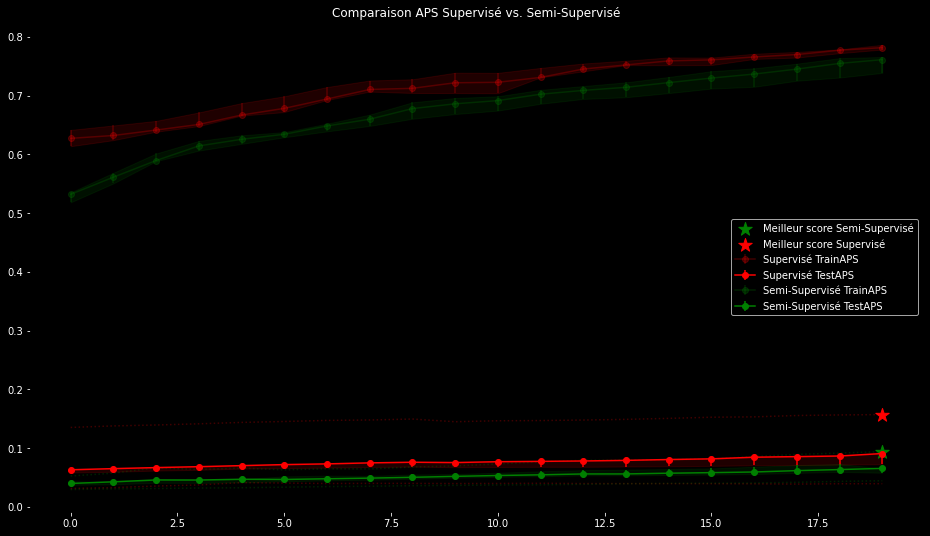


		Résumé de la métrique AUC :
		Max AUC Semi-Supervisé: 0.732 (epoch: 18)
		Max AUC Supervisé:      0.777 (epoch: 17)

		Semi-Supervisé: -4.41%
		


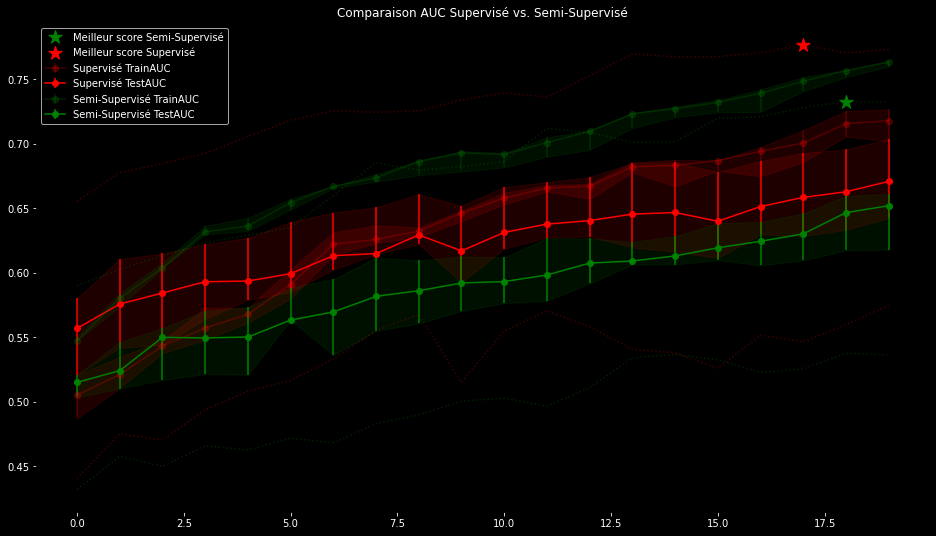

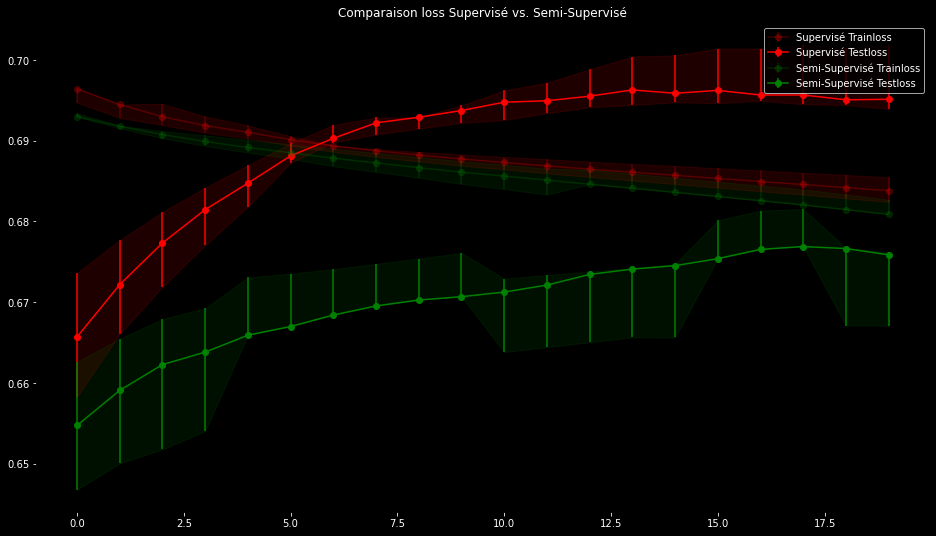

In [26]:
errorbar = True
fill_between = True
plot_resume("APS", errorbar=errorbar, fill_between=fill_between)
plot_resume("AUC", errorbar=errorbar, fill_between=fill_between)
plot_resume("loss", errorbar=errorbar, fill_between=fill_between, plot_max=False)

In [ ]:


thresholds = 0.5 # limite pour l'arrondissement

y_true = sup_test[:,:1].reshape(-1, )
y_pred_score = D_lonly.predict(sup_test[:,1:]).reshape(-1, )
y_pred = np.where(y_pred_score > thresholds, 1, 0)

print(np.unique(y_true, return_counts=True))
print(np.unique(y_pred, return_counts=True))
"""
Matrice de confusion  | Pred 0 | Pred 1 | Total
			Réalité 0 |   VN   |   FP   | de non observation dans la base
			Réalité 1 |   FN   |   VP   | d'observation dans la base
"""
# https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# Precision
# = VP / (VP + FP)
# = VP / P
# = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# f1 = moyenne harmonique de Precision et Recall

precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
f1 = f1_score(precision, recall)
AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
print(f"""
Precision: 	{precision}
Recall: 	{recall}
f1_score: 	{f1}
AUC: 		{AUC}
Matrice de confusion:\n{confusion_matrix}
""")

# le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)

Ancienne evaluation (3 neurones softmax)

In [ ]:
histnp = np.asarray(hist)


w, h = 16*2, 9
plt.figure(figsize=(w, h), dpi=80)
plt.plot(histnp[:,[0, 1]])
plt.show()

In [ ]:
histnp = np.asarray(hist)
w, h = 8, 9/2

plt.figure(figsize=(w, h))
plt.title("G / D loss")
plt.plot(histnp[:,[12, 17]])
plt.show()


plt.figure(figsize=(w, h))
plt.title("G / D ACC label")
plt.plot(histnp[:,[15, 20]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("G / D ACC reality")
plt.plot(histnp[:,[16, 21]])
plt.show()


In [ ]:
histnp = np.asarray(hist)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

w, h = 8, 9/2
plt.figure(figsize=(w, h))
plt.title("GAN D / G loss")
plt.plot(histnp[:,0:2])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test LOSS")
plt.plot(histnp[:,[2,2+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Label LOSS")
plt.plot(histnp[:,[3,3+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Reality LOSS")
plt.plot(histnp[:,[4,4+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Label ACC")
plt.plot(histnp[:,[5,5+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Reality ACC")
plt.plot(histnp[:,[6,6+5]])
plt.show()


In [ ]:
X = np.array(sup_train[:,1:].tolist())
labels = sup_train[:,0]
pred = np.argmax(D(X), axis=1)
display(np.array([labels, pred]).T)
display(D.evaluate(X, labels))

pred_ignore_G = np.argmax(D(X)[:, 0:2], axis=1)
display(np.array([labels, pred_ignore_G]).T)
display(tf.keras.metrics.binary_accuracy(labels, pred_ignore_G).numpy())

In [ ]:
X = np.array(sup_test[:,1:].tolist())
labels = sup_test[:,0]
pred = np.argmax(D(X), axis=1)
display(np.array([labels, pred]).T)
display(D.evaluate(X, labels))

pred_ignore_G = np.argmax(D(X)[:, 0:2], axis=1)
display(np.array([labels, pred_ignore_G]).T)
display(tf.keras.metrics.binary_accuracy(labels, pred_ignore_G).numpy())

In [ ]:
X, y = generate_fake_samples(10000, 1, G, latent_dim)
pred = np.argmax(D(X), axis=1)
display(np.array([y, pred[np.newaxis].T]).T)
D.evaluate(X, y)
X, y = generate_fake_samples(10000, 0, G, latent_dim)
pred = np.argmax(D(X), axis=1)
display(np.array([y, pred[np.newaxis].T]).T)
D.evaluate(X, y)